# Przygotowanie środowiska

## 1. Instalacja zależności

Przed przystąpieniem do tego ćwiczenia proszę zainstalować moduł 'pysnmp' oraz 'pysnmp-mibs' poleceniem: 'pip install pysnmp pysnmp-mibs'

## 2. Konfiguracja sieci
### 2.1 Topologia
Proszę w grupach zbudować następująca topologię sieciową:<br>
<img src="http://www.kt.agh.edu.pl/~rzym/lectures/TI-SSiZ/topo_snmp_lab_2022.png">

### 2.2 Konfiguracja
Proszę skonfigurować rutery tak, aby:
- miały dostęp do Internetu,
- jeden z interfejsów otrzymał adres IP z DHCP,
- był skonfugurowany agent snmp (wersja 2c) z community 'public' (read-only) oraz 'private' (read-write)

#### Przydatne polecenia:
(config-if)# ip address dhcp<br>
(config)# snmp-server community public RO<br>
(config)# snmp-server community private RW

# Połączenie z urządzeniem (zestawianie sesji SNMP)
## Import wymaganych zależności:

In [1]:
import threading
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from pysnmp.entity.rfc3413.oneliner import cmdgen
import time

### Przykładowe pobranie opisu urządzenia przez SNMP (SNMP-GET)

In [2]:
cmdGen = cmdgen.CommandGenerator()

errorIndication, errorStatus, errorIndex, varBinds = cmdGen.getCmd(
    cmdgen.CommunityData('public'),
    cmdgen.UdpTransportTarget(('10.160.68.191', 161)),
    cmdgen.ObjectIdentity('SNMPv2-MIB', 'sysDescr', 0),
    lookupNames=True, lookupValues=True)

name, value = varBinds[0]

print(name)
print(value)
print("\n#########################\n")
print(name.prettyPrint())
print(value.prettyPrint())

1.3.6.1.2.1.1.1.0
Cisco IOS Software [Everest], ISR Software (X86_64_LINUX_IOSD-UNIVERSALK9-M), Version 16.6.4, RELEASE SOFTWARE (fc3)
Technical Support: http://www.cisco.com/techsupport
Copyright (c) 1986-2018 by Cisco Systems, Inc.
Compiled Sun 08-Jul-18 04:33 by mcpr

#########################

SNMPv2-MIB::sysDescr.0
Cisco IOS Software [Everest], ISR Software (X86_64_LINUX_IOSD-UNIVERSALK9-M), Version 16.6.4, RELEASE SOFTWARE (fc3)
Technical Support: http://www.cisco.com/techsupport
Copyright (c) 1986-2018 by Cisco Systems, Inc.
Compiled Sun 08-Jul-18 04:33 by mcpr


In [4]:
print(errorIndication)

None


## Wylistowanie wszystkich interfejsów i ich parametrów (SNMP-WALK)

In [5]:
cmdGen = cmdgen.CommandGenerator()

errorIndication, errorStatus, errorIndex, varBinds = cmdGen.nextCmd(
    cmdgen.CommunityData('public'),
    cmdgen.UdpTransportTarget(('10.160.68.191', 161)),
    cmdgen.ObjectIdentity('IF-MIB'),
    lookupNames=True, lookupValues=True)

for varBind in varBinds:
    print(' = '.join([x.prettyPrint() for x in varBind]))

IF-MIB::ifNumber.0 = 9
IF-MIB::ifIndex.1 = 1
IF-MIB::ifIndex.2 = 2
IF-MIB::ifIndex.3 = 3
IF-MIB::ifIndex.4 = 4
IF-MIB::ifIndex.5 = 5
IF-MIB::ifIndex.6 = 6
IF-MIB::ifIndex.7 = 7
IF-MIB::ifIndex.8 = 8
IF-MIB::ifIndex.9 = 9
IF-MIB::ifDescr.1 = GigabitEthernet0/0/0
IF-MIB::ifDescr.2 = GigabitEthernet0/0/1
IF-MIB::ifDescr.3 = Serial0/1/0
IF-MIB::ifDescr.4 = Serial0/1/1
IF-MIB::ifDescr.5 = GigabitEthernet0/2/0
IF-MIB::ifDescr.6 = GigabitEthernet0/2/1
IF-MIB::ifDescr.7 = GigabitEthernet0
IF-MIB::ifDescr.8 = VoIP-Null0
IF-MIB::ifDescr.9 = Null0
IF-MIB::ifType.1 = ethernetCsmacd
IF-MIB::ifType.2 = ethernetCsmacd
IF-MIB::ifType.3 = propPointToPointSerial
IF-MIB::ifType.4 = propPointToPointSerial
IF-MIB::ifType.5 = ethernetCsmacd
IF-MIB::ifType.6 = ethernetCsmacd
IF-MIB::ifType.7 = ethernetCsmacd
IF-MIB::ifType.8 = other
IF-MIB::ifType.9 = other
IF-MIB::ifMtu.1 = 1500
IF-MIB::ifMtu.2 = 1500
IF-MIB::ifMtu.3 = 1500
IF-MIB::ifMtu.4 = 1500
IF-MIB::ifMtu.5 = 1500
IF-MIB::ifMtu.6 = 1500
IF-MIB::ifMtu.7

In [6]:
def get_bytesIn():
    errorIndication, errorStatus, errorIndex, varBinds = cmdGen.getCmd(
        cmdgen.CommunityData('public'),
        cmdgen.UdpTransportTarget(('10.160.68.191', 161)),
        cmdgen.ObjectIdentity('IF-MIB', 'ifInOctets', 1),
        lookupNames=True, lookupValues=True)

    name, value = varBinds[0]
    return int(value.prettyPrint()) 

## Wyswietlanie statystyk w czasie rzeczywistym
### Poniżej zaprezentowano przykładową metodę pobierania wartości liczników dla danych w kierunku wychodzącym z urządzenia w bajtach dla interfejsu o indeksie 1:

In [7]:
def get_bytes():
    errorIndication, errorStatus, errorIndex, varBinds = cmdGen.getCmd(
        cmdgen.CommunityData('public'),
        cmdgen.UdpTransportTarget(('10.160.68.191', 161)),
        cmdgen.ObjectIdentity('IF-MIB', 'ifOutOctets', 1),
        lookupNames=True, lookupValues=True)

    name, value = varBinds[0]
    return int(value.prettyPrint())

Metoda 'stats_worker()' uruchamia proces w tle, który co 3 sekundy odpytuje ruter o wartości liczników (korzystając z metody 'get_bytes()' i wpisuje je do prostego bufora (listy o nazwie 'bytes'). Za każym razem usuwany jest pierwszy element listy ('bytes.pop(0)'), a następnie na koniec listy dodawana jest ostatnio odczytana wartość (' bytes.append(int(get_bytes()))'). W ten sposób prosty bufor utrzymuje stały rozmiar zdefiniowanych w metodzie 'main()' programu.

In [8]:
def stats_worker():
    threading.Timer(1.0, stats_worker).start()
    bytes.pop(0)
    bytes.append(get_bytes())
    bytesIn.append(get_bytesIn())
    tput.pop(0)
    tput.append(bytes[-1]-bytes[-2])
    tputIn.pop(0)
    tputIn.append(bytesIn[-1]-bytesIn[-2])

W metodzie 'main()' następuje przygotowanie dwóch list (buforów) o nazwach 'bytes' i 'tput' oraz uruchomienie pobierania statystyk.

In [9]:
if __name__== "__main__":
    cmdGen = cmdgen.CommandGenerator()
    bytes = [0]*10
    tput = [0]*10
    bytesIn = [0]*10
    tputIn = [0]*10
    stats_worker()

Przykład kodu pozwalającego wyświetlić zawartość bufora 'bytes' w czasie rzeczywistym:

<IPython.core.display.Javascript object>


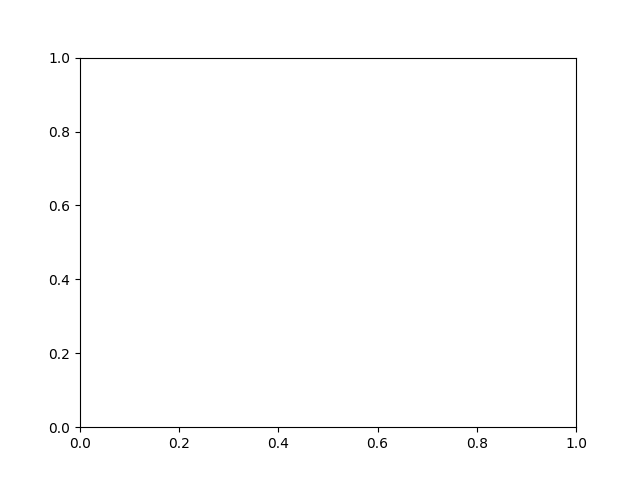

KeyboardInterrupt: 

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

while True:
    ax.clear()
    ax.plot(bytes)
    fig.canvas.draw()
    time.sleep(1)

### Zadanie: Proszę przygotować kod aplikacji, która to będzie rysowała w czasie rzeczywistym (np. co 1 sekundę) przepustowość interfejsu w wybranym kierunku. Proszę dodać opisy osi.
### Zadanie domowe: Proszę przygotować kod aplikacji, która będzie co sekundę rysowała przepustowość łącza do Internetu w obu kierunkach na raz (np. z wykorzystaniem subplot).

<IPython.core.display.Javascript object>


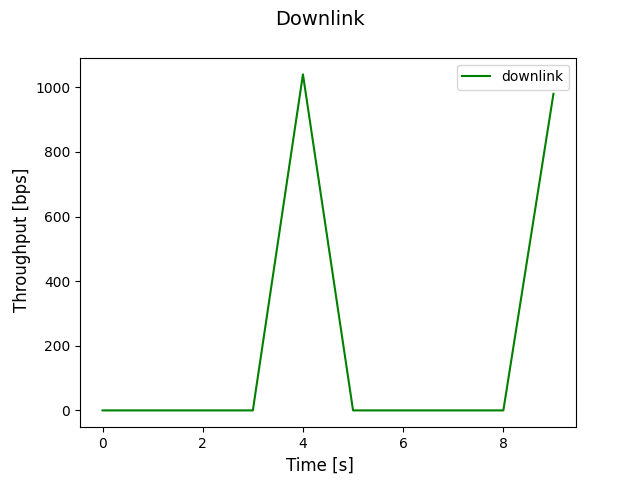

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [32]:
#Zadanie 1
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.set_label('downlink')

plt.title('Downlink')
plt.legend()

plt.ion()

fig.supxlabel('Time [s]')
fig.suptitle("Downlink", fontsize=14)
fig.supylabel('Throughput [bps]')
fig.show()
fig.canvas.draw()

while True:
    ax.clear()
    ax2.clear()
    #ax.plot(bytes)
    plt.plot(tputIn,color='g', label='downlink')
    plt.legend()
    fig.canvas.draw()
    time.sleep(1)


<IPython.core.display.Javascript object>


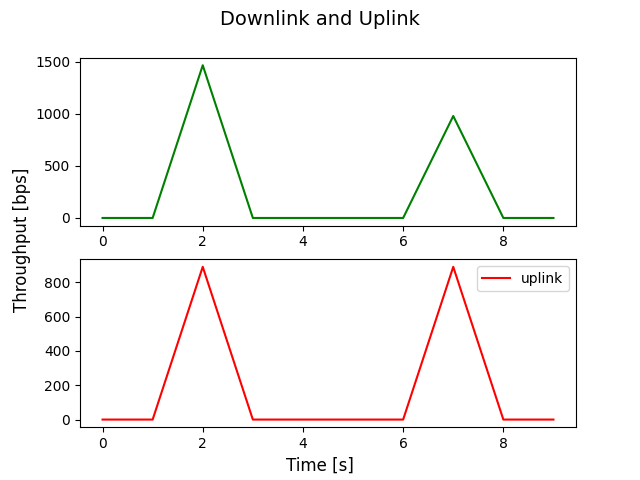

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [37]:
#Zadanie 2
fig, axs = plt.subplots(2)

axs[0].set_label('downlink')
axs[1].set_label('uplink')

axs[0].set(xlabel='Time [s]', ylabel='Throughput [bps]')
axs[1].set(xlabel='Time [s]', ylabel='Throughput [bps]')



plt.legend()
plt.ion()

fig.supxlabel('Time [s]')
fig.suptitle("Downlink and Uplink", fontsize=14)
fig.supylabel('Throughput [bps]')

fig.show()
fig.canvas.draw()

while True:
    axs[0].clear()
    axs[1].clear()
  
    #ax.plot(bytes)
    axs[0].plot(tputIn,color='g', label='downlink')
    axs[1].plot(tput,color='r', label='uplink')
    plt.legend()
    fig.canvas.draw()
    time.sleep(1)